# Tomato Disease Detector with PyTorch

## 1. Plot the UMAPP Clustering

### 1.1. Import all libraries required

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.preprocessing import StandardScaler

### 1.2. Load dataset

In [2]:
data_dir = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/full"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = dataset.classes
print(f"Found {len(dataset)} images across {len(class_names)} classes: {class_names}")

Found 28326 images across 11 classes: ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']


### 1.3. Extract features using pretrained CNN

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Use pretrained ResNet50 backbone
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # remove classifier
model.eval().to(device)

features = []
labels = []

with torch.no_grad():
    for imgs, lbls in loader:
        imgs = imgs.to(device)
        output = model(imgs)              # shape: (batch, 2048, 1, 1)
        output = output.squeeze()         # shape: (batch, 2048)
        features.append(output.cpu().numpy())
        labels.extend(lbls.numpy())

features = np.vstack(features)
labels = np.array(labels)

print(f"Extracted feature matrix shape: {features.shape}")

Extracted feature matrix shape: (28326, 2048)


### 1.4. Normalize and reduce with UMAP

In [4]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

umap = UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embeddings_2d = umap.fit_transform(features_scaled)

C:\Users\ekadw\anaconda3\envs\PyTorch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### 1.5. Plot UMAP clusters

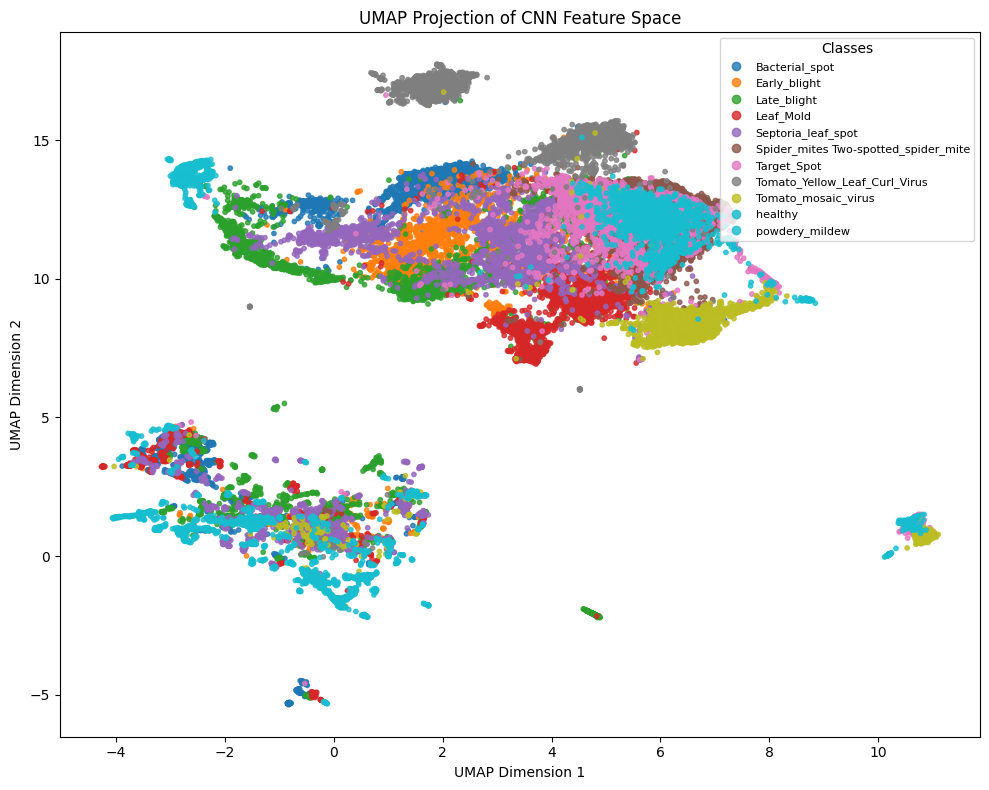

In [5]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                      c=labels, cmap='tab10', s=10, alpha=0.8)
plt.legend(handles=scatter.legend_elements()[0],
           labels=class_names, title="Classes",
           loc="best", fontsize=8)
plt.title("UMAP Projection of CNN Feature Space")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.tight_layout()
plt.show()

## 2. Checking the quality of image dataset

In [6]:
import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import imagehash
from torchvision import transforms, models
import torch
import shutil

RAW_DATA_DIR = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/full"
CLEAN_DATA_DIR = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/clean_tomato_leaves"
os.makedirs(CLEAN_DATA_DIR, exist_ok=True)

### 2.1. Region of interest (ROI) by cropping only the tomato leaf

In [7]:
def extract_leaf_roi(image_path, save_path, min_area=500):
    img = cv2.imread(image_path)
    if img is None:
        return False
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_green = np.array([20, 30, 20])
    upper_green = np.array([100, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest = max(contours, key=cv2.contourArea)
        if cv2.contourArea(largest) >= min_area:
            x, y, w, h = cv2.boundingRect(largest)
            img = img[y:y+h, x:x+w]

    cv2.imwrite(save_path, img)
    return True

# Recursive ROI extraction
for root, dirs, files in os.walk(RAW_DATA_DIR):
    for file in tqdm(files, desc=f"Processing {os.path.basename(root)}"):
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        src_path = os.path.join(root, file)

        # Preserve subfolder structure
        rel_path = os.path.relpath(root, RAW_DATA_DIR)
        save_dir = os.path.join(CLEAN_DATA_DIR, rel_path)
        os.makedirs(save_dir, exist_ok=True)

        dst_path = os.path.join(save_dir, file)
        extract_leaf_roi(src_path, dst_path)

print("ROI extraction complete.")

Processing full: 0it [00:00, ?it/s]
Processing Tomato_Yellow_Leaf_Curl_Virus: 100%|██████████| 2526/2526 [00:06<00:00, 380.63it/s]

ROI extraction complete.


### 2.2. Image duplicate detection

In [8]:
def remove_duplicates_recursive(base_dir, hash_size=16, threshold=5):
    for class_folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, class_folder)
        if not os.path.isdir(folder_path):
            continue

        hashes = {}
        removed = 0

        for file in tqdm(os.listdir(folder_path), desc=f"Checking duplicates in {class_folder}"):
            if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            path = os.path.join(folder_path, file)
            try:
                with Image.open(path) as img:
                    h = imagehash.phash(img, hash_size=hash_size)
            except:
                os.remove(path)
                continue

            duplicate = any(abs(h - ex_hash) < threshold for ex_hash in hashes.values())
            if duplicate:
                os.remove(path)
                removed += 1
            else:
                hashes[file] = h

        print(f"Removed {removed} duplicates in {class_folder}")

remove_duplicates_recursive(CLEAN_DATA_DIR)

Checking duplicates in Bacterial_spot: 100%|██████████| 2970/2970 [01:00<00:00, 48.97it/s]


Removed 0 duplicates in Bacterial_spot


Checking duplicates in Early_blight: 100%|██████████| 2715/2715 [00:53<00:00, 51.18it/s]


Removed 0 duplicates in Early_blight


Checking duplicates in healthy: 100%|██████████| 3151/3151 [01:06<00:00, 47.73it/s]


Removed 2 duplicates in healthy


Checking duplicates in Late_blight: 100%|██████████| 3291/3291 [01:10<00:00, 46.44it/s]


Removed 2 duplicates in Late_blight


Checking duplicates in Leaf_Mold: 100%|██████████| 2939/2939 [00:58<00:00, 50.01it/s]


Removed 0 duplicates in Leaf_Mold


Checking duplicates in powdery_mildew: 100%|██████████| 956/956 [00:13<00:00, 72.16it/s]


Removed 0 duplicates in powdery_mildew


Checking duplicates in Septoria_leaf_spot: 100%|██████████| 3107/3107 [00:55<00:00, 55.81it/s]


Removed 1 duplicates in Septoria_leaf_spot


Checking duplicates in Spider_mites Two-spotted_spider_mite: 100%|██████████| 2177/2177 [00:34<00:00, 63.70it/s]


Removed 0 duplicates in Spider_mites Two-spotted_spider_mite


Checking duplicates in Target_Spot: 100%|██████████| 2248/2248 [00:34<00:00, 65.01it/s]


Removed 0 duplicates in Target_Spot


Checking duplicates in Tomato_mosaic_virus: 100%|██████████| 2246/2246 [00:37<00:00, 60.68it/s]


Removed 0 duplicates in Tomato_mosaic_virus


Checking duplicates in Tomato_Yellow_Leaf_Curl_Virus: 100%|██████████| 2526/2526 [00:41<00:00, 60.42it/s]

Removed 0 duplicates in Tomato_Yellow_Leaf_Curl_Virus


### 2.3. Image quality check

In [9]:
def is_blurry(image_path, threshold=30):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return True
    lap_var = cv2.Laplacian(img, cv2.CV_64F).var()
    return lap_var < threshold

def remove_low_quality_images_recursive(base_dir, min_size=(64, 64)):
    total_removed = 0
    for root, dirs, files in os.walk(base_dir):
        removed = 0
        for file in files:
            path = os.path.join(root, file)
            try:
                img = cv2.imread(path)
                if img is None:
                    os.remove(path)
                    continue
                h, w = img.shape[:2]
                if h < min_size[0] or w < min_size[1] or is_blurry(path):
                    os.remove(path)
                    removed += 1
            except:
                os.remove(path)
                removed += 1
        if removed:
            print(f"Removed {removed} low-quality images in {root}")
            total_removed += removed
    print(f"✅ Total removed: {total_removed}")

remove_low_quality_images_recursive(CLEAN_DATA_DIR)

Removed 43 low-quality images in C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/clean_tomato_leaves\Bacterial_spot
Removed 6 low-quality images in C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/clean_tomato_leaves\Early_blight
Removed 11 low-quality images in C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/clean_tomato_leaves\healthy
Removed 25 low-quality images in C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/clean_tomato_leaves\Late_blight
Removed 38 low-quality images in C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/clean_tomato_leaves\Leaf_Mold
Removed 93 low-quality images in C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/clean_tomato_leaves\powdery_mildew
Removed 21 low-quality images in C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/clean_tomato_leaves\Septoria_leaf_spot
Removed 4 low-quality images in C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/clean_tomato_leaves\Target_Spot
Removed 1 low-quality images in C:

### 2.4. Outlier detection by using PCA and UMAP

Extracted features: (28033, 2048)


C:\Users\ekadw\anaconda3\envs\PyTorch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Detected 841 outliers out of 28033


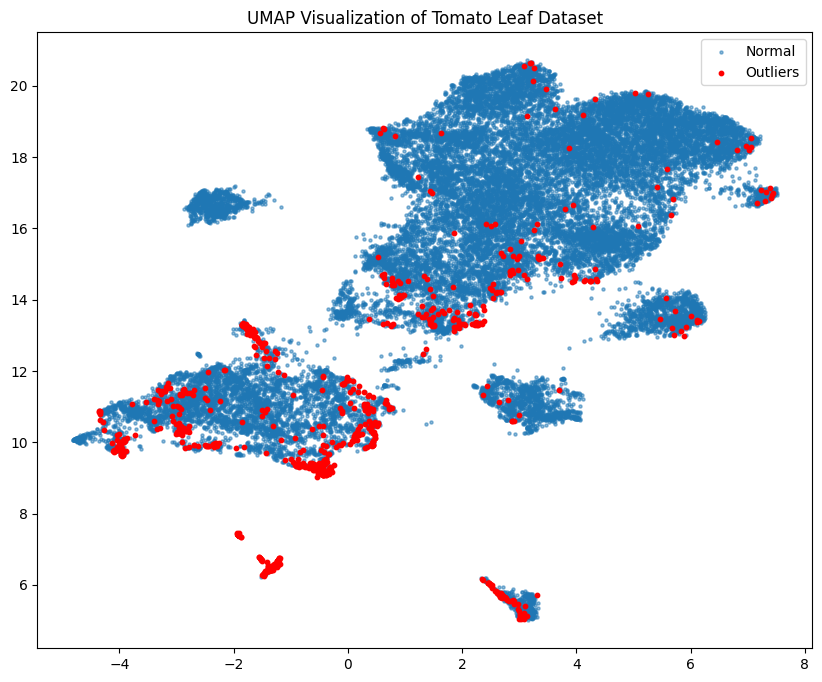

In [10]:
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import umap
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet50(weights="IMAGENET1K_V2")
model = torch.nn.Sequential(*list(model.children())[:-1])
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def extract_features(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = model(x).cpu().numpy().flatten()
        return feat
    except:
        return None

features, paths = [], []

for root, dirs, files in os.walk(CLEAN_DATA_DIR):
    for file in files:
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        path = os.path.join(root, file)
        feat = extract_features(path)
        if feat is not None:
            features.append(feat)
            paths.append(path)

features = np.array(features)
print("Extracted features:", features.shape)

if len(features) > 0:
    # PCA + UMAP
    pca = PCA(n_components=50).fit_transform(features)
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(pca)

    # Outlier detection
    iso = IsolationForest(contamination=0.03, random_state=42)
    preds = iso.fit_predict(pca)

    outliers = preds == -1
    print(f"Detected {outliers.sum()} outliers out of {len(outliers)}")

    # Visualize
    plt.figure(figsize=(10, 8))
    plt.scatter(embedding[~outliers, 0], embedding[~outliers, 1], s=5, label="Normal", alpha=0.5)
    plt.scatter(embedding[outliers, 0], embedding[outliers, 1], s=10, color="red", label="Outliers")
    plt.legend()
    plt.title("UMAP Visualization of Tomato Leaf Dataset")
    plt.show()

    # Remove outlier images
    for i, is_outlier in enumerate(outliers):
        if is_outlier:
            os.remove(paths[i])

## 3. Plot the cluster of clean image dataset


🔍 Step 1: Removing duplicates...


Bacterial_spot: 100%|██████████| 2970/2970 [00:16<00:00, 180.76it/s]


  ↳ Removed 0 duplicates in Bacterial_spot


Early_blight: 100%|██████████| 2715/2715 [00:15<00:00, 176.86it/s]


  ↳ Removed 0 duplicates in Early_blight


healthy: 100%|██████████| 3151/3151 [00:18<00:00, 167.43it/s]


  ↳ Removed 0 duplicates in healthy


Late_blight: 100%|██████████| 3291/3291 [00:20<00:00, 157.50it/s]


  ↳ Removed 0 duplicates in Late_blight


Leaf_Mold: 100%|██████████| 2939/2939 [00:17<00:00, 166.06it/s]


  ↳ Removed 0 duplicates in Leaf_Mold


powdery_mildew: 100%|██████████| 957/957 [00:02<00:00, 377.79it/s]


  ↳ Removed 1 duplicates in powdery_mildew


Septoria_leaf_spot: 100%|██████████| 3107/3107 [00:20<00:00, 155.13it/s]


  ↳ Removed 0 duplicates in Septoria_leaf_spot


Spider_mites Two-spotted_spider_mite: 100%|██████████| 2177/2177 [00:10<00:00, 209.66it/s]


  ↳ Removed 0 duplicates in Spider_mites Two-spotted_spider_mite


Target_Spot: 100%|██████████| 2248/2248 [00:11<00:00, 204.15it/s]


  ↳ Removed 0 duplicates in Target_Spot


Tomato_mosaic_virus: 100%|██████████| 2246/2246 [00:12<00:00, 186.51it/s]


  ↳ Removed 0 duplicates in Tomato_mosaic_virus


Tomato_Yellow_Leaf_Curl_Virus: 100%|██████████| 2526/2526 [00:13<00:00, 190.53it/s]


  ↳ Removed 0 duplicates in Tomato_Yellow_Leaf_Curl_Virus
✅ Total duplicates removed: 1

🍃 Step 2: Extracting ROI regions...


Processing full: 0it [00:00, ?it/s]
Processing Tomato_Yellow_Leaf_Curl_Virus: 100%|██████████| 2526/2526 [00:05<00:00, 460.22it/s]


✅ ROI extraction complete.

🧹 Step 3: Removing low-quality images...
  ↳ Removed 43 low-quality images in C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/clean_tomato_leaves\Bacterial_spot
  ↳ Removed 6 low-quality images in C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/clean_tomato_leaves\Early_blight
  ↳ Removed 11 low-quality images in C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/clean_tomato_leaves\healthy
  ↳ Removed 25 low-quality images in C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/clean_tomato_leaves\Late_blight
  ↳ Removed 38 low-quality images in C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/clean_tomato_leaves\Leaf_Mold
  ↳ Removed 93 low-quality images in C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/clean_tomato_leaves\powdery_mildew
  ↳ Removed 21 low-quality images in C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/clean_tomato_leaves\Septoria_leaf_spot
  ↳ Removed 4 low-quality images in C:/Users/ekadw/Docum

C:\Users\ekadw\anaconda3\envs\PyTorch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Detected 842 outliers out of 28039


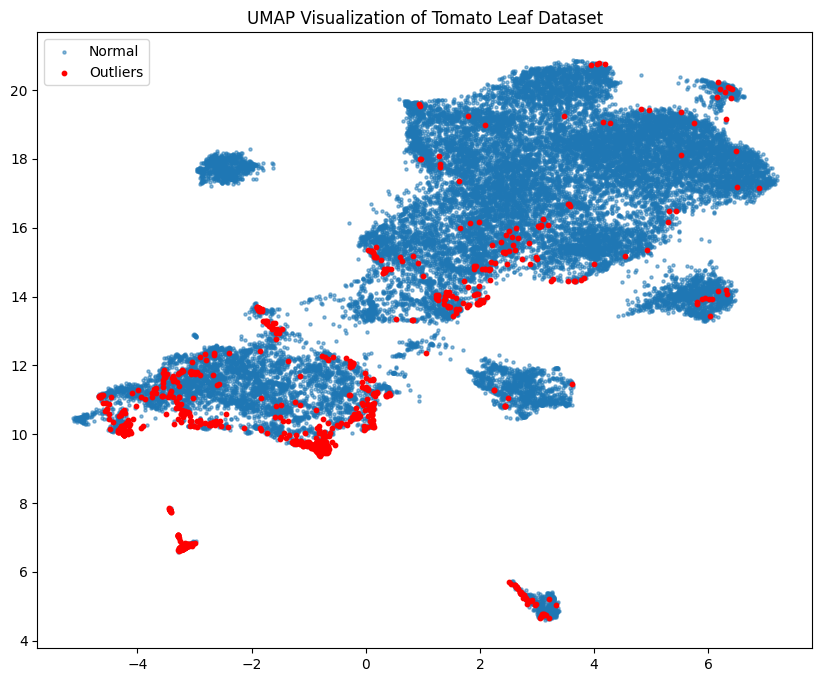

✅ Final dataset ready for CNN training!


In [2]:
import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import imagehash
import torch
from torchvision import models, transforms
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import umap
import matplotlib.pyplot as plt
import shutil

# ===============================
# CONFIGURATION
# ===============================
RAW_DATA_DIR = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/full"
CLEAN_DATA_DIR = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/clean_tomato_leaves"
os.makedirs(CLEAN_DATA_DIR, exist_ok=True)

# ===============================
# STEP 1: REMOVE DUPLICATES
# ===============================
def remove_duplicates_recursive(base_dir, hash_size=16, threshold=5):
    print("\n🔍 Step 1: Removing duplicates...")
    total_removed = 0
    for class_folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, class_folder)
        if not os.path.isdir(folder_path):
            continue

        hashes = {}
        removed = 0
        for file in tqdm(os.listdir(folder_path), desc=f"{class_folder}"):
            if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            path = os.path.join(folder_path, file)
            try:
                with Image.open(path) as img:
                    h = imagehash.phash(img, hash_size=hash_size)
            except:
                os.remove(path)
                continue

            duplicate = any(abs(h - ex_hash) < threshold for ex_hash in hashes.values())
            if duplicate:
                os.remove(path)
                removed += 1
            else:
                hashes[file] = h

        total_removed += removed
        print(f"  ↳ Removed {removed} duplicates in {class_folder}")

    print(f"✅ Total duplicates removed: {total_removed}\n")

remove_duplicates_recursive(RAW_DATA_DIR)

# ===============================
# STEP 2: ROI EXTRACTION
# ===============================
def extract_leaf_roi(image_path, save_path, min_area=500):
    img = cv2.imread(image_path)
    if img is None:
        return False

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_green = np.array([20, 30, 20])
    upper_green = np.array([100, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest = max(contours, key=cv2.contourArea)
        if cv2.contourArea(largest) >= min_area:
            x, y, w, h = cv2.boundingRect(largest)
            img = img[y:y+h, x:x+w]

    cv2.imwrite(save_path, img)
    return True

print("🍃 Step 2: Extracting ROI regions...")
for root, dirs, files in os.walk(RAW_DATA_DIR):
    for file in tqdm(files, desc=f"Processing {os.path.basename(root)}"):
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        src_path = os.path.join(root, file)
        rel_path = os.path.relpath(root, RAW_DATA_DIR)
        save_dir = os.path.join(CLEAN_DATA_DIR, rel_path)
        os.makedirs(save_dir, exist_ok=True)
        dst_path = os.path.join(save_dir, file)
        extract_leaf_roi(src_path, dst_path)

print("✅ ROI extraction complete.\n")

# ===============================
# STEP 3: QUALITY FILTERING
# ===============================
def is_blurry(image_path, threshold=30):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return True
    lap_var = cv2.Laplacian(img, cv2.CV_64F).var()
    return lap_var < threshold

def remove_low_quality_images_recursive(base_dir, min_size=(64, 64)):
    print("🧹 Step 3: Removing low-quality images...")
    total_removed = 0
    for root, dirs, files in os.walk(base_dir):
        removed = 0
        for file in files:
            path = os.path.join(root, file)
            try:
                img = cv2.imread(path)
                if img is None:
                    os.remove(path)
                    continue
                h, w = img.shape[:2]
                if h < min_size[0] or w < min_size[1] or is_blurry(path):
                    os.remove(path)
                    removed += 1
            except:
                os.remove(path)
                removed += 1
        if removed:
            print(f"  ↳ Removed {removed} low-quality images in {root}")
            total_removed += removed
    print(f"✅ Total low-quality removed: {total_removed}\n")

remove_low_quality_images_recursive(CLEAN_DATA_DIR)

# ===============================
# STEP 4: VISUAL QUALITY CHECK (PCA + UMAP)
# ===============================
print("📊 Step 4: Visualizing with PCA + UMAP...")

device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet50(weights="IMAGENET1K_V2")
model = torch.nn.Sequential(*list(model.children())[:-1])
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def extract_features(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = model(x).cpu().numpy().flatten()
        return feat
    except:
        return None

features, paths = [], []
for root, dirs, files in os.walk(CLEAN_DATA_DIR):
    for file in files:
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        path = os.path.join(root, file)
        feat = extract_features(path)
        if feat is not None:
            features.append(feat)
            paths.append(path)

features = np.array(features)
print(f"Extracted {len(features)} feature vectors")

if len(features) > 0:
    pca = PCA(n_components=50).fit_transform(features)
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(pca)

    iso = IsolationForest(contamination=0.03, random_state=42)
    preds = iso.fit_predict(pca)

    outliers = preds == -1
    print(f"Detected {outliers.sum()} outliers out of {len(outliers)}")

    plt.figure(figsize=(10, 8))
    plt.scatter(embedding[~outliers, 0], embedding[~outliers, 1], s=5, label="Normal", alpha=0.5)
    plt.scatter(embedding[outliers, 0], embedding[outliers, 1], s=10, color="red", label="Outliers")
    plt.legend()
    plt.title("UMAP Visualization of Tomato Leaf Dataset")
    plt.show()

    for i, is_outlier in enumerate(outliers):
        if is_outlier:
            os.remove(paths[i])

print("✅ Final dataset ready for CNN training!")

### 3.1. Import all libraries required

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.decomposition import PCA
import umap
import torch
from torchvision import models, transforms

### 3.2. Load pretrained model for embeddings

In [ ]:
CLEAN_DATA_DIR = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/clean_tomato_leaves"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet50(weights="IMAGENET1K_V2")
model = torch.nn.Sequential(*list(model.children())[:-1])  # remove final FC layer
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

### 3.3. Extract Features

In [ ]:
features = []
labels = []
class_names = sorted(os.listdir(CLEAN_DATA_DIR))

for label_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(CLEAN_DATA_DIR, class_name)
    if not os.path.isdir(class_dir):
        continue
    print(f"Extracting features from class: {class_name}")
    for file in tqdm(os.listdir(class_dir), desc=f"{class_name}"):
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        img_path = os.path.join(class_dir, file)
        try:
            img = Image.open(img_path).convert("RGB")
            x = transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                feat = model(x).cpu().numpy().flatten()
            features.append(feat)
            labels.append(label_idx)
        except Exception as e:
            print(f"Error on {img_path}: {e}")

features = np.array(features)
labels = np.array(labels)

print(f"Total samples: {len(labels)}")
print("Feature shape:", features.shape)

### 3.4. PCA and UMAP Reduction

In [ ]:
pca = PCA(n_components=50).fit_transform(features)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(pca)

print("UMAP embedding shape:", embedding.shape)

### 3.5. Plot clusters

In [ ]:
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    mask = labels == i
    plt.scatter(
        embedding[mask, 0],
        embedding[mask, 1],
        s=10,
        label=class_name,
        alpha=0.7
    )

plt.title("UMAP Clustering of Tomato Leaf Dataset (Post-Cleaning)")
plt.legend()
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

Extracting features from class: Bacterial_spot


Bacterial_spot: 100%|██████████| 2801/2801 [02:56<00:00, 15.83it/s]


Extracting features from class: Early_blight


Early_blight: 100%|██████████| 2684/2684 [02:51<00:00, 15.63it/s]


Extracting features from class: Late_blight


Late_blight: 100%|██████████| 3140/3140 [03:21<00:00, 15.57it/s]


Extracting features from class: Leaf_Mold


Leaf_Mold: 100%|██████████| 2781/2781 [02:57<00:00, 15.70it/s]


Extracting features from class: Septoria_leaf_spot


Septoria_leaf_spot: 100%|██████████| 3017/3017 [03:13<00:00, 15.61it/s]


Extracting features from class: Spider_mites Two-spotted_spider_mite


Spider_mites Two-spotted_spider_mite: 100%|██████████| 2170/2170 [02:17<00:00, 15.81it/s]


Extracting features from class: Target_Spot


Target_Spot: 100%|██████████| 2224/2224 [02:21<00:00, 15.77it/s]


Extracting features from class: Tomato_Yellow_Leaf_Curl_Virus


Tomato_Yellow_Leaf_Curl_Virus: 100%|██████████| 2430/2430 [02:34<00:00, 15.78it/s]


Extracting features from class: Tomato_mosaic_virus


Tomato_mosaic_virus: 100%|██████████| 2218/2218 [02:19<00:00, 15.86it/s]


Extracting features from class: healthy


healthy: 100%|██████████| 3033/3033 [03:25<00:00, 14.73it/s]


Extracting features from class: powdery_mildew


powdery_mildew: 100%|██████████| 694/694 [00:43<00:00, 16.07it/s]


Total samples: 27192
Feature shape: (27192, 2048)


C:\Users\ekadw\anaconda3\envs\PyTorch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (27192, 2)


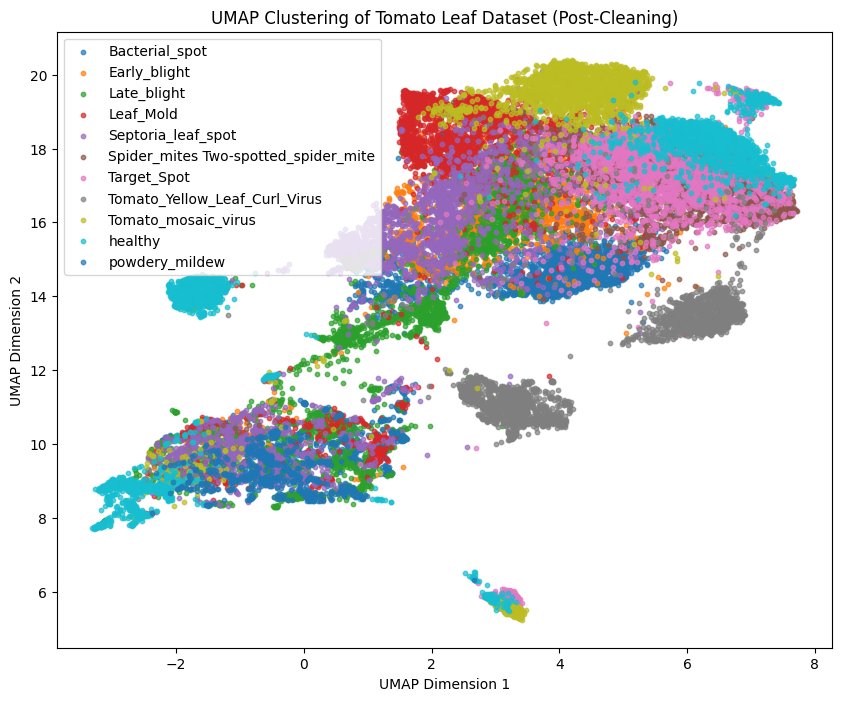

In [11]:


# ===============================
# STEP 4: PLOT CLUSTERS
# ===============================
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    mask = labels == i
    plt.scatter(
        embedding[mask, 0],
        embedding[mask, 1],
        s=10,
        label=class_name,
        alpha=0.7
    )

plt.title("UMAP Clustering of Tomato Leaf Dataset (Post-Cleaning)")
plt.legend()
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

## 4. Training with pre training MobileNetV2 model

### 4.1. Step by step

In [12]:
"""
Tomato Leaf Disease Classification with MobileNetV2 (PyTorch, CPU-optimized)

Steps:
1. Check dataset & target distribution
2. Data augmentation and normalization
3. Train/val/test split
4. Compute class weights
5. Build MobileNetV2 (pretrained)
6. Train base model (frozen)
7. Fine-tune top layers
8. Evaluate model
9. Save model and class indices

Author: Eka Dwipayana (optimized for CPU training)
"""

'\nTomato Leaf Disease Classification with MobileNetV2 (PyTorch, CPU-optimized)\n\nSteps:\n1. Check dataset & target distribution\n2. Data augmentation and normalization\n3. Train/val/test split\n4. Compute class weights\n5. Build MobileNetV2 (pretrained)\n6. Train base model (frozen)\n7. Fine-tune top layers\n8. Evaluate model\n9. Save model and class indices\n\nAuthor: Eka Dwipayana (optimized for CPU training)\n'

### 4.2. Import all libraries required

In [13]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import multiprocessing

### 4.3. Setup and optimize the CPU computing

In [14]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cpu")
NUM_WORKERS = max(1, multiprocessing.cpu_count() - 1)
BATCH_SIZE = 16
DATA_DIR = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/clean_tomato_leaves"  # <-- change this to your dataset root

print(f"Using {NUM_WORKERS} CPU cores")
print(f"Using device: {device}")

Using 11 CPU cores
Using device: cpu


### 4.4. Explore target distribution

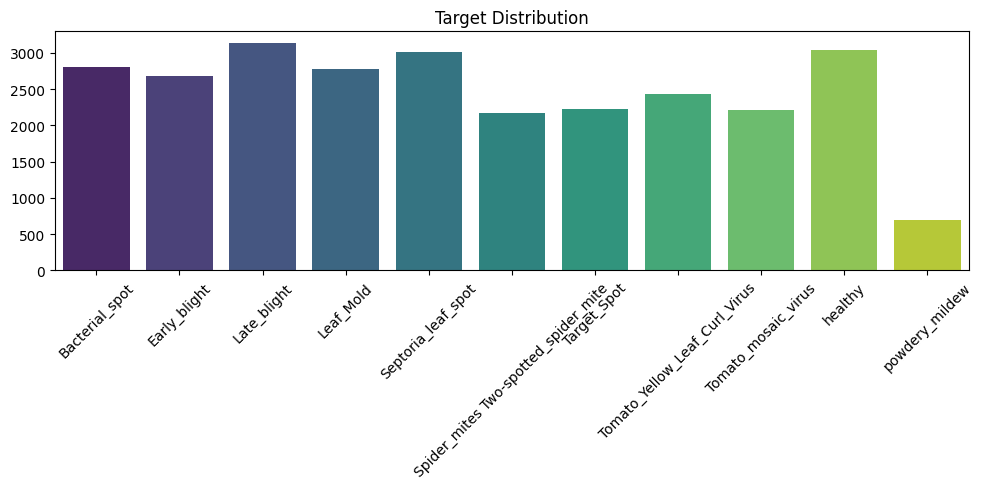

In [15]:
classes = sorted(os.listdir(DATA_DIR))
counts = {cls: len(os.listdir(os.path.join(DATA_DIR, cls))) for cls in classes}

plt.figure(figsize=(10, 5))
sns.barplot(
    x=list(counts.keys()),
    y=list(counts.values()),
    hue=list(counts.keys()),
    palette="viridis",
    legend=False
)
plt.title("Target Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4.5. Data transformation with augmentation

In [16]:
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(DATA_DIR, transform=train_tfms)

train_size = int(0.7 * len(dataset))
val_size   = int(0.2 * len(dataset))
test_size  = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
val_ds.dataset.transform = val_tfms
test_ds.dataset.transform = val_tfms

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Train: 19034, Val: 5438, Test: 2720


### 4.6. Class weight for imbalance dataset

In [17]:
targets = [dataset.samples[i][1] for i in range(len(dataset))]
class_weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class Weights:", class_weights)

Class Weights: tensor([0.8825, 0.9210, 0.7873, 0.8889, 0.8194, 1.1392, 1.1115, 1.0173, 1.1145,
        0.8150, 3.5620])


### 4.7. Pretrained model setup

In [18]:
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
for param in model.features.parameters():
    param.requires_grad = False

num_classes = len(classes)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.2)

### 4.8. Training function with early stoppage

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15, patience=5, save_path="best_model.pth"):
    best_acc = 0.0
    best_epoch = 0
    epochs_no_improve = 0
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss, correct, total = 0, 0, 0

        for imgs, labels in tqdm(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        scheduler.step(val_loss)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch
            torch.save(model.state_dict(), save_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    print(f"Best Val Acc: {best_acc:.4f} at epoch {best_epoch+1}")
    return history

### 4.9. Train baseline model

In [20]:
history = train_model(model, criterion, optimizer, scheduler, num_epochs=15, patience=5, save_path="mobilenetv2_base.pth")


Epoch 1/15


100%|██████████| 1190/1190 [07:37<00:00,  2.60it/s]


Train Acc: 0.7139 | Val Acc: 0.8130

Epoch 2/15


100%|██████████| 1190/1190 [07:54<00:00,  2.51it/s]


Train Acc: 0.7876 | Val Acc: 0.8545

Epoch 3/15


100%|██████████| 1190/1190 [07:49<00:00,  2.54it/s]


Train Acc: 0.7911 | Val Acc: 0.8457

Epoch 4/15


100%|██████████| 1190/1190 [07:54<00:00,  2.51it/s]


Train Acc: 0.8018 | Val Acc: 0.8369

Epoch 5/15


100%|██████████| 1190/1190 [08:15<00:00,  2.40it/s]


Train Acc: 0.8056 | Val Acc: 0.8365

Epoch 6/15


100%|██████████| 1190/1190 [07:36<00:00,  2.61it/s]


Train Acc: 0.8019 | Val Acc: 0.8634

Epoch 7/15


100%|██████████| 1190/1190 [07:54<00:00,  2.51it/s]


Train Acc: 0.8051 | Val Acc: 0.8556

Epoch 8/15


100%|██████████| 1190/1190 [07:37<00:00,  2.60it/s]


Train Acc: 0.8123 | Val Acc: 0.8499

Epoch 9/15


100%|██████████| 1190/1190 [07:35<00:00,  2.62it/s]


Train Acc: 0.8037 | Val Acc: 0.8656

Epoch 10/15


100%|██████████| 1190/1190 [07:36<00:00,  2.61it/s]


Train Acc: 0.8088 | Val Acc: 0.8656

Epoch 11/15


100%|██████████| 1190/1190 [07:34<00:00,  2.62it/s]


Train Acc: 0.8074 | Val Acc: 0.8637

Epoch 12/15


100%|██████████| 1190/1190 [07:36<00:00,  2.61it/s]


Train Acc: 0.8098 | Val Acc: 0.8569

Epoch 13/15


100%|██████████| 1190/1190 [07:35<00:00,  2.61it/s]


Train Acc: 0.8065 | Val Acc: 0.8643

Epoch 14/15


100%|██████████| 1190/1190 [07:35<00:00,  2.61it/s]


Train Acc: 0.8278 | Val Acc: 0.8803

Epoch 15/15


100%|██████████| 1190/1190 [07:35<00:00,  2.61it/s]


Train Acc: 0.8315 | Val Acc: 0.8748
Best Val Acc: 0.8803 at epoch 14


### 4.10. Fine tunning by unfreeze the last 3 layers

In [ ]:
for param in model.features[-3:].parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-4)
history_ft = train_model(model, criterion, optimizer, scheduler, num_epochs=10, patience=4, save_path="mobilenetv2_finetuned.pth")


Epoch 1/10


100%|██████████| 1190/1190 [08:16<00:00,  2.40it/s]


Train Acc: 0.8469 | Val Acc: 0.9095

Epoch 2/10


100%|██████████| 1190/1190 [08:25<00:00,  2.35it/s]


Train Acc: 0.9051 | Val Acc: 0.9397

Epoch 3/10


100%|██████████| 1190/1190 [09:22<00:00,  2.11it/s]


Train Acc: 0.9302 | Val Acc: 0.9351

Epoch 4/10


100%|██████████| 1190/1190 [09:07<00:00,  2.17it/s]


Train Acc: 0.9439 | Val Acc: 0.9404

Epoch 5/10


100%|██████████| 1190/1190 [09:03<00:00,  2.19it/s]


Train Acc: 0.9521 | Val Acc: 0.9419

Epoch 6/10


100%|██████████| 1190/1190 [09:15<00:00,  2.14it/s]


### 4.11. Plot training history

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Training vs Validation Accuracy (Base)")
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history_ft["train_acc"], label="Train Acc (FT)")
plt.plot(history_ft["val_acc"], label="Val Acc (FT)")
plt.title("Fine-tuning Accuracy")
plt.legend()
plt.show()

### 4.12. Evaluate on test set

In [ ]:
model.load_state_dict(torch.load("mobilenetv2_finetuned.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=classes))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.show()

### 4.13. Save model and class indices

In [ ]:
torch.save(model.state_dict(), "mobilenetv2_tomato_best.pth")
class_to_idx = dataset.class_to_idx
with open("class_indices.json", "w") as f:
    json.dump(class_to_idx, f)
print("Model and class indices saved successfully.")

### 4.14. Create requirements.txt

In [ ]:
reqs = [
    "torch",
    "torchvision",
    "numpy",
    "matplotlib",
    "scikit-learn",
    "tqdm",
    "seaborn",
    "pandas",
    "Pillow"
]
with open("requirements.txt", "w") as f:
    f.write("\n".join(reqs))
print("requirements.txt created.")